In [1]:
#Dan Clayton
#DSC-630
#Assignment 4.2 Clustering Exercise

In [2]:
#Import some important libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import sklearn.metrics as metrics
import sklearn.cluster as cluster
import seaborn as sns
from sklearn import datasets
from yellowbrick.cluster import SilhouetteVisualizer

#Make it a little easier to see more output
pd.set_option('display.max_rows', 500)

In [3]:
#Install yellowbrick package
#import sys
#!{sys.executable} -m pip install yellowbrick

In [4]:
#Import Data
df = pd.read_csv('als_data.csv')

In [5]:
df

,ID,Age_mean,Albumin_max,Albumin_median,Albumin_min,Albumin_range,ALSFRS_slope,ALSFRS_Total_max,ALSFRS_Total_median,ALSFRS_Total_min,...,Sodium_min,Sodium_range,SubjectID,trunk_max,trunk_median,trunk_min,trunk_range,Urine.Ph_max,Urine.Ph_median,Urine.Ph_min
0,1,65,57.0,40.5,38.0,0.066202,-0.965608,30,28.0,22,...,143.0,0.017422,533,8,7.0,7,0.002646,6.00,6.0,6.0
1,2,48,45.0,41.0,39.0,0.010453,-0.921717,37,33.0,21,...,136.0,0.010453,649,8,7.0,5,0.005386,7.00,5.0,5.0
2,3,38,50.0,47.0,45.0,0.008929,-0.914787,24,14.0,10,...,140.0,0.008929,1234,5,0.0,0,0.008929,6.00,5.0,5.0
3,4,63,47.0,44.0,41.0,0.012111,-0.598361,30,29.0,24,...,138.0,0.012469,2492,5,5.0,3,0.004988,7.00,6.0,5.0
4,5,63,47.0,45.5,42.0,0.008292,-0.444039,32,27.5,20,...,138.0,0.008292,2956,6,4.0,1,0.008489,6.00,5.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2218,2419,33,50.0,49.0,45.0,0.008772,-0.239501,35,32.5,30,...,136.0,0.014035,997136,7,5.0,5,0.003643,7.00,6.0,5.0
2219,2420,61,47.0,45.0,42.0,0.009074,-0.388711,31,26.0,17,...,141.0,0.009074,998047,5,4.0,3,0.003630,7.41,5.5,5.0
2220,2421,47,46.0,44.0,41.0,0.012111,-0.108631,26,23.0,20,...,135.0,0.013123,998773,5,4.0,4,0.001825,9.00,6.0,5.0
2221,2422,37,49.0,44.0,39.0,0.017857,-0.855880,34,29.5,21,...,136.0,0.007143,998908,8,4.5,2,0.010714,6.00,5.0,5.0


In [6]:
#1) Remove any data that is not relevant to the patient's ALS condition

#Build the correlation matrix (assuming all variables are continuous--not strictly speaking true, but anything that isn't will be dropped later on)
corr_matrix = df.corr()

#Check out the results
#print(corr_matrix["ALSFRS_Total_median"].sort_values(ascending=False))

#Dataframe to store the results
cm_df = corr_matrix["ALSFRS_Total_median"].sort_values(ascending=False).to_frame()

#Add absolute value to this dataframe
cm_df['ABS val'] = cm_df['ALSFRS_Total_median'].abs()

#Drop any rows with less material values (arbitrarily chosen to be 45%)
cm_df = cm_df[cm_df['ABS val'] >= 0.45]

#The remaining rows are the data relevant to ALS diagnosis
features = list(cm_df.index)

#Manually remove ALSFRS Max and Min (assumed to be redundent with median)
features.remove('ALSFRS_Total_max')
features.remove('ALSFRS_Total_min')

#Show the remaining data rows
print(features)

#Change the dataframe to only include the relevant data
for col in df:
    if col not in(features):
        df.drop(col, axis=1, inplace=True)

#Remove the ALFSRS measure from the features list
features.remove('ALSFRS_Total_median')

#Check out the results
df

['ALSFRS_Total_median', 'trunk_median', 'hands_median', 'trunk_max', 'trunk_min', 'hands_min', 'hands_max', 'leg_median', 'leg_min', 'leg_max', 'mouth_min', 'mouth_median', 'mouth_range']


,ALSFRS_Total_median,hands_max,hands_median,hands_min,leg_max,leg_median,leg_min,mouth_median,mouth_min,mouth_range,trunk_max,trunk_median,trunk_min
0,28.0,8,7.5,6,8,6.5,4,3.5,0,0.013228,8,7.0,7
1,33.0,8,6.0,6,8,7.5,3,8.0,4,0.008977,8,7.0,5
2,14.0,4,1.0,0,4,3.0,2,7.0,4,0.010714,5,0.0,0
3,29.0,6,5.5,4,4,3.5,2,12.0,12,0.000000,5,5.0,3
4,27.5,8,6.5,3,2,2.0,0,12.0,12,0.000000,6,4.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2218,32.5,6,4.0,3,8,8.0,8,11.0,10,0.003643,7,5.0,5
2219,26.0,6,4.0,1,8,8.0,6,6.0,4,0.007260,5,4.0,3
2220,23.0,5,2.0,2,3,2.0,2,10.0,9,0.001825,5,4.0,4
2221,29.5,8,6.5,4,3,3.0,2,12.0,10,0.003571,8,4.5,2


In [7]:
#2) Apply a standard scalar to the data

#Define the scaler
scaler = StandardScaler()

#Scale the data
df_scaled = scaler.fit_transform(df.to_numpy())

#Convert the scaled data back into a dataframe
df_scaled = pd.DataFrame(df_scaled, columns=[df.columns])

#See how we did
df_scaled

,ALSFRS_Total_median,hands_max,hands_median,hands_min,leg_max,leg_median,leg_min,mouth_median,mouth_min,mouth_range,trunk_max,trunk_median,trunk_min
0,0.134960,0.919974,1.054904,1.132573,1.198700,1.074563,0.709255,-2.238477,-2.080167,1.082677,1.028018,0.981832,1.715365
1,0.888863,0.919974,0.445034,1.132573,1.198700,1.513108,0.238466,-0.614648,-1.010429,0.388826,1.028018,0.981832,0.867032
2,-1.975969,-1.103377,-1.587866,-1.168807,-0.583715,-0.460344,-0.232324,-0.975499,-1.010429,0.672452,-0.688950,-2.280669,-1.253800
3,0.285741,-0.091702,0.241744,0.365446,-0.583715,-0.241072,-0.232324,0.828756,1.129048,-1.076402,-0.688950,0.049689,0.018699
4,0.059570,0.919974,0.648324,-0.018117,-1.474923,-0.898889,-1.173903,0.828756,1.129048,-1.076402,-0.116627,-0.416383,-0.829634
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2218,0.813473,-0.091702,-0.368126,-0.018117,1.198700,1.732381,2.592413,0.467905,0.594179,-0.481770,0.455695,0.049689,0.867032
2219,-0.166601,-0.091702,-0.368126,-0.785243,1.198700,1.732381,1.650834,-1.336350,-1.010429,0.108544,-0.688950,-0.416383,0.018699
2220,-0.618943,-0.597539,-1.181286,-0.401680,-1.029319,-0.898889,-0.232324,0.107054,0.326744,-0.778543,-0.688950,-0.416383,0.442866
2221,0.361131,0.919974,0.648324,0.365446,-1.029319,-0.460344,-0.232324,0.828756,0.594179,-0.493450,1.028018,-0.183347,-0.405467


In [8]:
'''
#Loop through a number of different cluster numbers
score_x = []
score_y = []

for i in range(2,20):
    # Instantiate the KMeans models
    km = KMeans(n_clusters=i, random_state=42)

    # Fit the KMeans model
    km.fit_predict(df_scaled[features])

    # Calculate Silhoutte Score
    score = silhouette_score(df_scaled[features], km.labels_, metric='euclidean')

    # Print the score
    #print('Silhouetter Score: %.3f' % score)
    #score_tracker.append([i,score])
    score_x.append(i)
    score_y.append(score)
'''

"\n#Loop through a number of different cluster numbers\nscore_x = []\nscore_y = []\n\nfor i in range(2,20):\n    # Instantiate the KMeans models\n    km = KMeans(n_clusters=i, random_state=42)\n\n    # Fit the KMeans model\n    km.fit_predict(df_scaled[features])\n\n    # Calculate Silhoutte Score\n    score = silhouette_score(df_scaled[features], km.labels_, metric='euclidean')\n\n    # Print the score\n    #print('Silhouetter Score: %.3f' % score)\n    #score_tracker.append([i,score])\n    score_x.append(i)\n    score_y.append(score)\n"

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklea

IndexError: index 2 is out of bounds for axis 0 with size 2

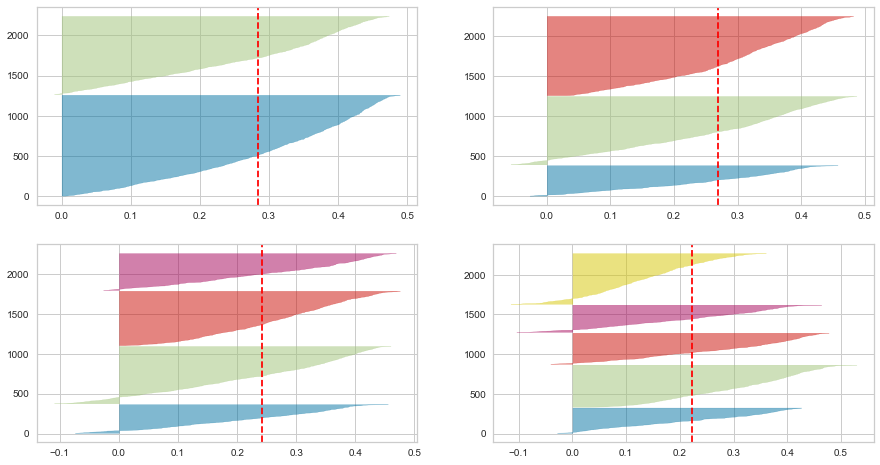

In [14]:
#3) Create a plot of the cluster silhouette score versus the number of clusters in the K-means cluster
fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in range(2,10):
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(df_scaled[features])

In [ ]:
#4) Use the plot created in (3) to choose an optimal number of clusters for K-means.  Justify your choice.
#4 clusters appears to be the ideal number because:
    #1) There is less variation in the cluster sizes
    #2) All of the clusters have above average silhouette scores


In [ ]:
#5) For a K-means model to the data with the optimal number of clusters chosen in part (4).

In [18]:
#6) Fit the PCA tranformation with two features to the scaled data.
print(cm_df)
#Using trunk_median and hands_median as they appear to have the most predictive power for ALSFRS_Total_median
best_features = ['trunk_median', 'hands_median']
# Instantiate the KMeans models
km = KMeans(n_clusters=4, random_state=42)

# Fit the KMeans model
km.fit_predict(df_scaled[best_features])

                     ALSFRS_Total_median   ABS val
ALSFRS_Total_median             1.000000  1.000000
ALSFRS_Total_max                0.874428  0.874428
trunk_median                    0.850799  0.850799
ALSFRS_Total_min                0.814057  0.814057
hands_median                    0.763911  0.763911
trunk_max                       0.741941  0.741941
trunk_min                       0.729634  0.729634
hands_min                       0.682683  0.682683
hands_max                       0.661319  0.661319
leg_median                      0.629515  0.629515
leg_min                         0.607473  0.607473
leg_max                         0.505627  0.505627
mouth_min                       0.481710  0.481710
mouth_median                    0.461300  0.461300
mouth_range                    -0.451429  0.451429


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


KMeans(n_clusters=4, random_state=42)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


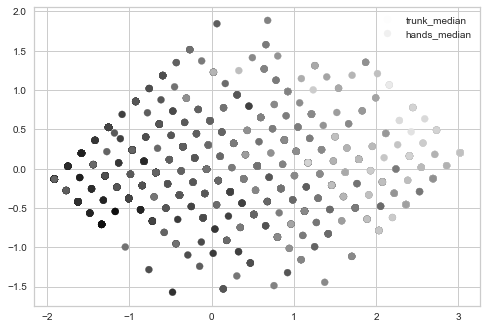

In [24]:
#7) Make a scatterplot of the PCA transformed data coloring each point by its cluster value
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
pca = PCA()
pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca)])
Xt = pipe.fit_transform(df_scaled[best_features])
plot = plt.scatter(Xt[:,0], Xt[:,1], c=df_scaled['ALSFRS_Total_median'])
plt.legend(handles=plot.legend_elements()[0], labels=list(best_features))
plt.show()

In [ ]:
#8) Summarize your results and make a conclusion
#This analysis was done wrong.  The clusters created are non-distinct and overlap prolifically, thus providing no predictive value whatsoever

#No conclusion can be made based on this poor output

#Perhaps a functional example of this assignment could be posted after grading is done?  
#I can't help but feel like none of the assigned readings or online resources gave sufficient preparation or guidance for this.